Code adapted from: 

Earth Lab's Earth Data Analytics -- Lesson 2. Subtract One Raster from Another and Export a New GeoTIFF in Open Source Python

https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/subtract-rasters-in-python/

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install rioxarray
!pip install earthpy

In [2]:
import os
import asdc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import earthpy as et

# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")
!pwd

/home/jovyan/tim.brown@anu.edu.au/canopy_height


In [3]:
print("Select the task to download the DSM and DTM from. Make sure the Task you have selected actually has both a DSM and a DTM file")
asdc.task_select()
from ipywidgets import widgets

Select the task to download the DSM and DTM from. Make sure the Task you have selected actually has both a DSM and a DTM file
Project not found:  None
Task not found:  None


interactive(children=(Dropdown(description='project', options=(('3: Misc Testing Projects', 3), ('5: Panorama …

interactive(children=(Dropdown(description='task', options=(('Task #f32b33c6-dbb2-495f-a0eb-c5b7404b5698', 'f3…

Button(description='Run all below', icon='play', style=ButtonStyle())

In [4]:
project_id, task_id = asdc.get_selection()
task_name = asdc.task_dict[task_id]['name']
project_id
task_id
print("Task name = ", task_name)

Task name =  USLN-Doran-2022-02-11-DJI-M3-ZackSimpson-RGB | 2023-04-17 (reprocess w/high res ortho settings)


Now we download the DSM and DTM files

In [5]:
base_name_for_outputs =  task_name.split(" |")[0]
temp_folder_name = "TEMP-" + base_name_for_outputs

task_data_folder_path = os.path.join(".", temp_folder_name)  # The '.' represents the current directory

print("Temporary files will be stored in the folder: \n\t" + task_data_folder_path)
print("\nNew files with have the base file name: \n\t" + base_name_for_outputs + "\n-----------------------------")

if not os.path.exists(task_data_folder_path):
    os.makedirs(task_data_folder_path)

Temporary files will be stored in the folder: 
	./TEMP-USLN-Doran-2022-02-11-DJI-M3-ZackSimpson-RGB

New files with have the base file name: 
	USLN-Doran-2022-02-11-DJI-M3-ZackSimpson-RGB
-----------------------------


Now we download the DSM and DTM files from the selected Task.

Note that this step will fail if your task doesn't have either of these files. 

If not, you will need to re-run the task and make sure creation of both DSM & DTM is enabled in the Task processing options.

In [7]:
# Use this code to download via URL rather than with the ASDC API
#  or if you want to have the DSM/DTM files have the task name
#   DSM_path = f"https://asdc.cloud.edu.au/api/projects/{project_id}/tasks/{task_id}/download/dsm.tif"
#   DTM_path = f"https://asdc.cloud.edu.au/api/projects/{project_id}/tasks/{task_id}/download/dtm.tif"

print("Downloading DSM and DTM files to: ", task_data_folder_path)

#NOTE: In ODM, the DEM is called a DTM

dtm_filename = 'dtm.tif'
dsm_filename = 'dsm.tif'

lidar_dtm_path = task_data_folder_path + "/" + dtm_filename
lidar_dsm_path = task_data_folder_path + "/" + dsm_filename

asdc.download_asset(dsm_filename, lidar_dsm_path)
asdc.download_asset(dtm_filename, lidar_dtm_path)

'./TEMP-USLN-Doran-2022-02-11-DJI-M3-ZackSimpson-RGB/dtm.tif'

Open and plot the lidar digital elevation model (DEM). Note that when you read the data, you can use the argument masked = True to ensure that the no data values do not plot and are assigned nan or nodata.

In [8]:
# Open lidar DTM
lidar_dtm_xr = rxr.open_rasterio(lidar_dtm_path, masked=True).squeeze()
lidar_dtm_xr

# Open lidar dsm
lidar_dsm_xr = rxr.open_rasterio(lidar_dsm_path, masked=True).squeeze()
lidar_dsm_xr

<xarray.DataArray (y: 2524, x: 3637)>
[9179788 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 6.625e+05 6.625e+05 ... 6.627e+05 6.627e+05
  * y            (y) float64 5.973e+06 5.973e+06 ... 5.973e+06 5.973e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

Import Digital Surface Model (DSM)
Next, you will open the digital surface model (DSM). The DSM represents the top of the earth’s surface. Thus, it includes trees, buildings and other objects that sit on the earth.

Before you subtract the two rasters. Before performing this calculate however you should check to ensure that they cover the same spatial extent and are of the same spatial resolution (pixel size).

In [9]:
# Are the bounds the same?
print("Is the spatial extent the same?",
      lidar_dtm_xr.rio.bounds() == lidar_dsm_xr.rio.bounds())

# Is the resolution the same ??
print("Is the resolution the same?",
      lidar_dtm_xr.rio.resolution() == lidar_dsm_xr.rio.resolution())

Is the spatial extent the same? True
Is the resolution the same? True


If it looks like the bounds and resolution are the same. This means it is safe for you to subtract the two rasters without significant errors or uncertainty introduced.

Below you calculate the difference between the two arrays to generate a Canopy Height Model. You then plot your newly created canopy height model.

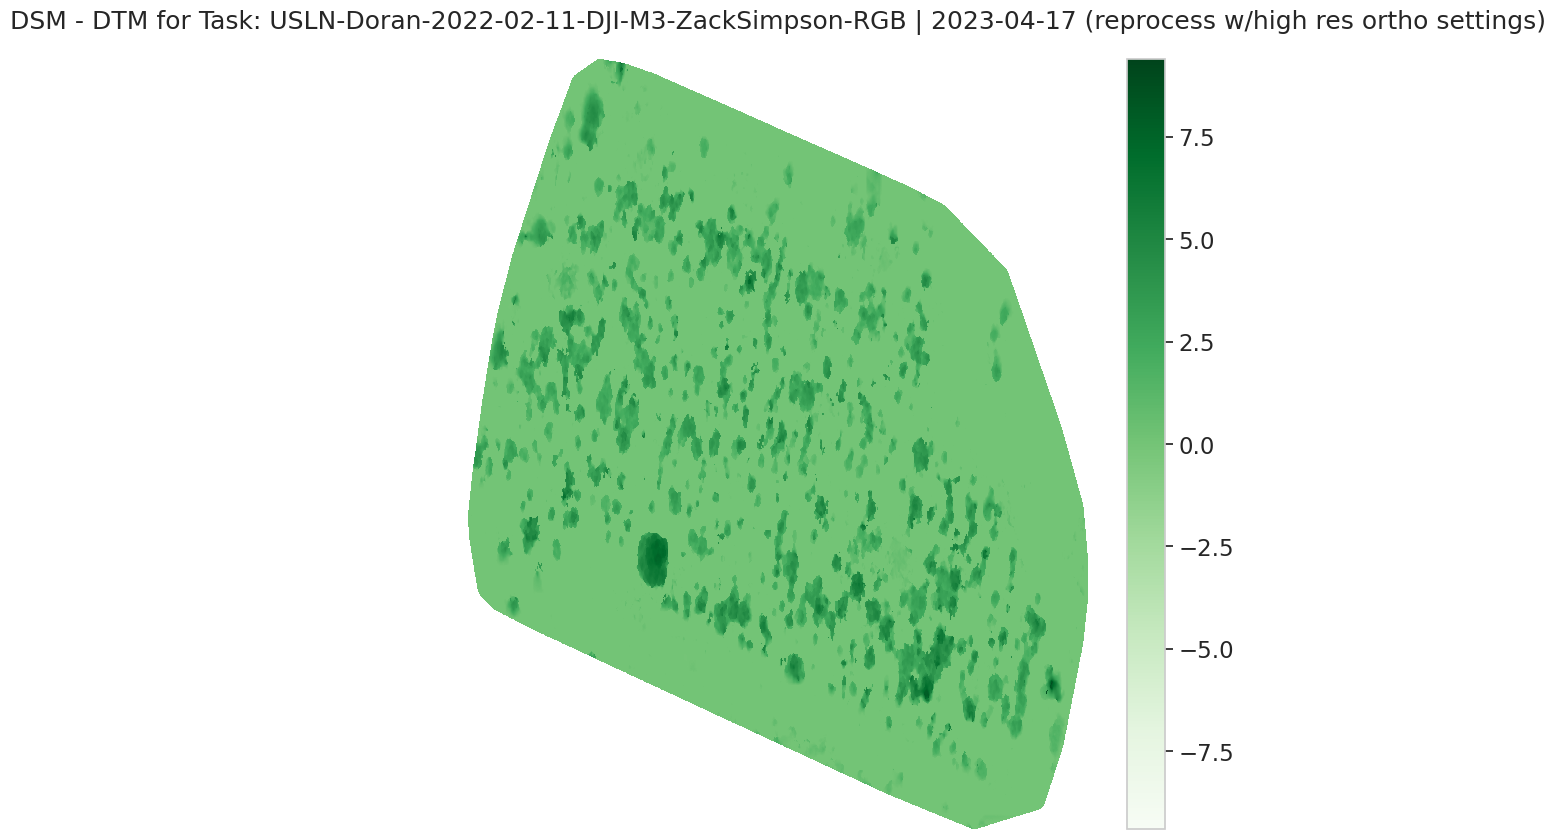

In [10]:
# Calculate canopy height model
lidar_chm_xr = lidar_dsm_xr - lidar_dtm_xr

# Plot the data
f, ax = plt.subplots(figsize=(10, 10))
lidar_chm_xr.plot(cmap="Greens")

ax.set(title=  "DSM - DTM for Task: " + task_name)
ax.set_axis_off()
plt.show()

In [11]:
#Normalize the DSM
lidar_chm_xr_min = lidar_chm_xr.min()
lidar_chm_xr_max = lidar_chm_xr.max()
normalized_dsm = (lidar_chm_xr - lidar_chm_xr_min) / (lidar_chm_xr_max - lidar_chm_xr_min)
normalized_dsm.rio.to_raster('normalized_dsm.tif')

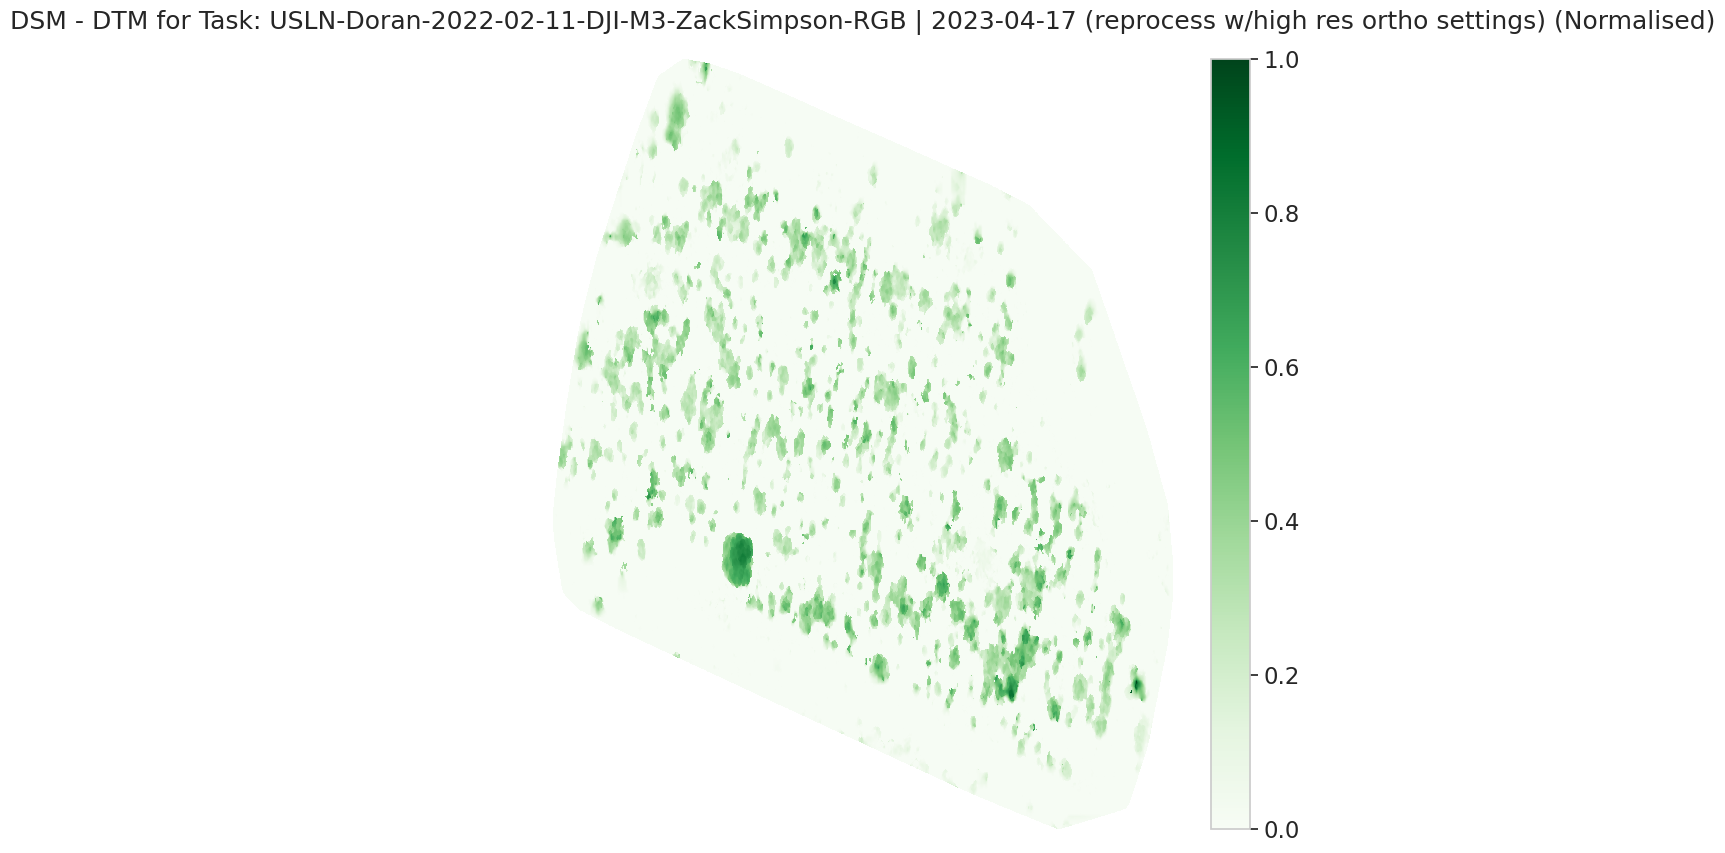

In [12]:
# Plot the nomarlised data
f, ax = plt.subplots(figsize=(10, 10))
normalized_dsm.plot(cmap="Greens")

ax.set(title=  "DSM - DTM for Task: " + task_name + " (Normalised)")
ax.set_axis_off()
plt.show()

Now we set a cutoff threshold and then find the bounding box for everything above that threshold.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy import ndimage

# Load the dtm
dtm = rxr.open_rasterio('normalized_dsm.tif')

# Set the minimum cutoff value
##  Note this since the heights have been nomalised, this is  a non-dimensional value that is essentially a percentage of the to
cutoff = 0.25

# Create a mask for values above the cutoff (trees)
tree_mask = dtm.data[0] > cutoff

# Label clusters of trees
labeled_array, num_features = ndimage.label(tree_mask)

# Find bounding boxes for each cluster
bounding_boxes = ndimage.find_objects(labeled_array)

Now we plot the dsm with the bounding boxes on it and save out the image

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Display the dtm
ax.imshow(dtm.data[0], cmap='gray', vmin=0, vmax=1)  # Adjusted for better contrast

# Overlay bounding boxes
for bbox in bounding_boxes:
    # Extract coordinates for the bounding box
    y_min, x_min = bbox[0].start, bbox[1].start
    y_max, x_max = bbox[0].stop, bbox[1].stop

    # Create a Rectangle patch
    rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                             linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

# Disable the grid
ax.grid(False)

# Save the figure without the grid
plt.savefig('dsm_with_bounding_boxes.png', dpi=300)

plt.show()

Check coordinate system of DSM

In [ ]:
# Load the GeoTIFF file
dtm = rxr.open_rasterio('dsm.tif')

# Print the CRS (Coordinate Reference System)
print("CRS:", dtm.rio.crs)

# Print the spatial bounds
print("Spatial bounds:", dtm.rio.bounds())


Now we convert the array of bounding boxes into lat/longs

In [ ]:
import rioxarray as rxr
import xarray as xr 
from pyproj import Transformer
from scipy import ndimage

# # Load the dtm
# dtm = rxr.open_rasterio('normalized_dsm.tif')

# # Set the minimum cutoff value
# cutoff = 0.2

# # Create a mask for values above the cutoff (trees)
# tree_mask = dtm.data[0] > cutoff

# # Label clusters of trees
# labeled_array, num_features = ndimage.label(tree_mask)

# # Find bounding boxes for each cluster
# bounding_boxes = ndimage.find_objects(labeled_array)

# Initialize coordinate transformation using Transformer
# From UTM (EPSG:32755) to WGS 84 (EPSG:4326)
transformer = Transformer.from_crs("epsg:32755", "epsg:4326", always_xy=True)

# Convert bounding boxes to lat/long
latlong_bounding_boxes = []
for bbox in bounding_boxes:
    # Unpack the slices into min and max coordinates
    y_min, y_max = bbox[0].start, bbox[0].stop
    x_min, x_max = bbox[1].start, bbox[1].stop

    # Convert pixel coordinates to UTM coordinates
    utm_x_min, utm_y_min = dtm.rio.transform() * (x_min, y_min)
    utm_x_max, utm_y_max = dtm.rio.transform() * (x_max, y_max)

    # Convert UTM to lat/long using the transformer
    lon_min, lat_min = transformer.transform(utm_x_min, utm_y_min)
    lon_max, lat_max = transformer.transform(utm_x_max, utm_y_max)

    # Store lat/long bounding boxes
    latlong_bounding_boxes.append((lat_min, lon_min, lat_max, lon_max))

# latlong_bounding_boxes now contains the bounding boxes in latitude and longitude


In [ ]:
print(latlong_bounding_boxes[:5])

In [ ]:
data_path = task_data_folder_path
if os.path.exists(data_path):
    print("The directory", data_path, "exists!")
else:
    os.makedirs(data_path)

# Make sure that your output data has a crs & no data value defined
print("The crs is", lidar_chm_xr.rio.crs)
print("The no data value is", lidar_chm_xr.rio.nodata)

Save TIF back to ODM

Now save out the bounding boxes as a new geotiff

In [ ]:
# Load the original DSM
import xarray as xr 
dtm = rxr.open_rasterio('normalized_dsm.tif')

# Create a blank raster with the same dimensions
bounding_box_raster = np.zeros_like(dtm.data[0])

# Assuming bounding_boxes is a list of bounding box coordinates
# You need to use the same bounding_boxes array that you calculated earlier

# Draw the bounding boxes onto the blank raster
for i, bbox in enumerate(bounding_boxes, start=1):  # Start numbering from 1
    y_slice, x_slice = bbox
    bounding_box_raster[y_slice, x_slice] = i  # Assign a unique value for each box


# Create a rioxarray object from the numpy array

bounding_box_raster_xr = xr.DataArray(bounding_box_raster, dims=dtm.dims[1:], coords={dim: dtm.coords[dim] for dim in dtm.dims[1:]})

# Copy the CRS and encoding from the original DSM
bounding_box_raster_xr.rio.write_crs(dtm.rio.crs, inplace=True)

# Save as a new GeoTIFF
bounding_box_raster_xr.rio.to_raster('bounding_boxes.tif')

NEXT STEP IS TO CONVERT IT TO A SHAPE FILE AND UPLOAD TO odm WHERE IT CAN BE VIEWED IN THE REGULAR VIEWER,

BUT WE NEED GDAL INSTALLED IN THE BASE JUPYTER IMAGE FIRST

In [ ]:
import geopandas as gpd
from shapely.geometry import box
import rioxarray as rxr

# Load the DEM to get the transform and CRS
dem = rxr.open_rasterio('normalized_dsm.tif')

# Assuming bounding_boxes is your array of bounding boxes
# Convert bounding box pixel coordinates to geographic coordinates
geom_list = []
for bbox in bounding_boxes:
    y_min, y_max = bbox[0].start, bbox[0].stop
    x_min, x_max = bbox[1].start, bbox[1].stop

    # Convert pixel coordinates to geographic coordinates
    xmin, ymin = dem.rio.transform() * (x_min, y_min)
    xmax, ymax = dem.rio.transform() * (x_max, y_max)

    # Create a shapely box (rectangle) from these coordinates
    geom = box(xmin, ymin, xmax, ymax)
    geom_list.append(geom)

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geom_list)

# Set the CRS of the GeoDataFrame to match the DEM
gdf.crs = dem.rio.crs

# Save to a shapefile
output_shapefile = 'bounding_boxes.shp'
gdf.to_file(output_shapefile)


In [ ]:
# This doesn't work yet, not sure why but once you add a "shapefiles" folder as an ODM asset it seems to break things in ODM
#  Note that this has been shown to work in the Fracture detection pipeline (see ASDC issue # 156)

r = asdc.upload_asset("bounding_boxes.shp", dest=f"shapefiles/bounding_boxes.shp", task=task_id)
if not r.ok: print(r)

In [ ]:
print(task_name)
print(f"/projects/{project_id}/tasks/{task_id}/assets/files.json")